# 3D (x-y-t) field inference: ensemble experiments

We start from a flow field generated with `drifter_3D.ipynb` and run multiple inferences with different draws of  mooring positions & drifters release positions as well as noise.

**Production**: runs are actually produced from scripts: `launch.pbs` and `drifter_3D_ensemble.py`

In [1]:
import os
from tqdm import tqdm
#import pickle

import numpy as np
import pandas as pd
import xarray as xr
import dask

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import corner
import arviz as az

import nwatools.stats as st
colors = st.colors
day = 86400

#data_dir = "data/"
#data_dir = "/home1/scratch/aponte/"
data_dir = "/home/datawork-lops-osi/aponte/nwa/drifter_stats"

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


ERROR 1: PROJ: proj_create_from_database: Open of /home1/datawork/aponte/miniconda3/envs/equinox/share/proj failed


In [2]:
# actually run production inferences
#prod=True
prod=False

local_cluster = True
if prod:
    local_cluster = False

if local_cluster:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()
else:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(cores=20, processes=20, walltime="03:00:00")
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="03:00:00")
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="00:30:00")
    # cores=7, processes=7, 02:00:00 by default
    w = cluster.scale(jobs=5)

client = Client(cluster)
client

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-message

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:48025,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:44623,Total threads: 7
Dashboard: http://127.0.0.1:53165/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:42550,


## Prepare distribution of computations

Computations to be distributed:

- Fixed station inference
- Lagrangian simulation and inference


In [2]:
# flow case
U = "0.1"
#case = "3D_matern32_iso_matern12_pp_r0.0_u"+U
case = "3D_matern52_iso_matern12_pp_r0.0_u"+U
run_dir = os.path.join(data_dir, case)

uv = True # True if u and v are observed
parameter_eta_formulation = False # eta vs nu formulation
noise = 0.01 # observation noise added to u/v
no_time = False # deactivates time scale inference - need overhaul
no_space = False # deactivates spatial scale inference
traj_decorrelation = False  # artificially decorrelate different moorings/drifters
#traj_decorrelation = True  # artificially decorrelate different moorings/drifters
if no_space:
    # makes little sense otherwise
    traj_decorrelation = True
assert not no_time, "need to implement decorrelation across time"

# number of points used for inference#
#Nxy, Nt = 1, 50
#Nxy, Nt = 2, 50
#Nxy, Nt = 4, 50
Nxy, Nt = 8, 50
#Nxy, Nt = 16, 50

#Nxy, Nt = 5, 50
#Nxy, Nt = 10, 50

# run multiple Nxy at once
#Nxy = [1, 2, 4, 8, 16]

# number of ensembles
#Ne = 10 # dev
Ne = 100 # prod

dx = None
#dx = 100. # Nxy>1, separation between platforms
#dx = [20, 50, 100, 150, 200]

burn = 500 # number of samples to drop (burning)

In [3]:
# prepare inference & common utils
dsf, covfunc, covparams, labels = st.prepare_inference(
    run_dir,
    uv, no_time, no_space,
    parameter_eta_formulation, traj_decorrelation,
)
flow_attrs = dict(**dsf.attrs)

U 0.1
amplitude0 7.745966692414835
amplitude1 0.0
cov_t matern12
cov_x matern52_iso
cov_y matern52_iso
eta 7.745966692414835
kind pp
lambda_t 5
lambda_x 100
lambda_y 100
nu_space 2.5
nu_time 0.5
noise 0.0
pp_ratio 0.0
dx 2.0
dy 2.0


---
## run/load inferences

### moorings

In [5]:
# dev
#ds = st.run_mooring_ensembles(5, dsf, covparams, covfunc, labels, (Nt, Nxy), noise, n_mcmc=100)

In [6]:
def run_mooring(Nxy, dx):    
    print(Nxy, dx)
    
    # build output file name
    nc = os.path.join(run_dir, f"moorings_ensemble_Nxy{Nxy}.nc")
    if dx is not None:
        nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")

    if prod and not os.path.isfile(nc):
        ds = st.run_mooring_ensembles(
            Ne, dsf, covparams, covfunc, labels, (Nt, Nxy), noise, dx=dx,
            no_time=no_time, no_space=no_space,
        ) 
        ds.to_netcdf(nc, mode="w")
    else:
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)

    # move noise last
    ds = ds.sel(parameter=['γ', 'λx', 'λt', 'σ'])

    return ds

if isinstance(dx, list):
    Dm = []
    for d in dx:
        Dm.append(run_mooring(Nxy, d))
    ds = Dm[0]
elif isinstance(Nxy, list):
    Dm = []
    for n in Nxy:
        Dm.append(run_mooring(n, dx))
    ds = Dm[0]
else:
    ds = run_mooring(Nxy, dx)

mo = ds

8 None


### drifters

- Lagrangian simulation
- actual inference


In [7]:
# dev
#ds = st.run_drifter_ensembles(data_dir, case, Ne, covparams, covfunc, labels, (Nt, Nxy), noise, n_mcmc=100) # dev: delete None

# wrapper
def run_drifter(Nxy, dx):
    print(Nxy, dx)

    # build output file name    
    nc = os.path.join(run_dir, f"drifters_ensemble_Nxy{Nxy}.nc")
    if dx is not None:
        nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")

    if prod and not os.path.isfile(nc):
        ds = st.run_drifter_ensembles(
            data_dir, case, Ne, covparams, covfunc, labels, (Nt, Nxy), noise, dx=dx,
            no_time=no_time, no_space=no_space,
        ) 
        ds.to_netcdf(nc, mode="w")
    else:
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)
    
    # move noise last
    ds = ds.sel(parameter=['γ', 'λx', 'λt', 'σ'])
    
    return ds

if isinstance(dx, list):
    Dr = []
    for d in dx:
        Dr.append(run_drifter(Nxy, d))
    ds = Dr[0]
elif isinstance(Nxy, list):
    Dr = []
    for n in Nxy:
        Dr.append(run_drifter(n, dx))
    ds = Dr[0]
else:
    ds = run_drifter(Nxy, dx)

dr = ds

8 None


---

## joint mooring/drifters inference performance

In [14]:
dr.MAP.quantile([1/4,3/4], "ensemble")

<xarray.DataArray 'MAP' (quantile: 2, parameter: 4)>
array([[7.42919153e-02, 9.41046005e+01, 4.68741208e+00, 2.59951584e-03],
       [7.78590689e-02, 1.04592665e+02, 5.54231142e+00, 1.50140863e-02]])
Coordinates:
  * parameter  (parameter) <U2 'γ' 'λx' 'λt' 'σ'
  * quantile   (quantile) float64 0.25 0.75

In [19]:
# MAP distribution

def plot():

    fig, axes = plt.subplot_mosaic(
        [['(a)', '(b)', '(c)', '(d)']],
        layout='constrained',
        figsize=(10,3),
        dpi=300,
    )
    
    #fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))
    
    alpha = 0.5
    
    nbins = 30
    bins = dict(
        σ=np.linspace(0,.03,nbins),
        γ=np.linspace(0.5, 1.5,nbins)*float(mo.true_parameters.sel(parameter="γ", ensemble=0)),
        λx=np.linspace(0,250,nbins),
        λt=np.linspace(2,8,nbins),
    )
    units = dict(
        σ="[m/s]",
        #η="[m/s x km]",
        γ="[m/s]",
        λx="[km]",
        λt="[days]",
    )

    labels = mo.parameter.values
    labels = [r"${}_{}$".format(l[0], "s") if l=="λx" else l for l in labels]
    labels = [r"${}_{}$".format(l[0], "t") if l=="λt" else l for l in labels]    
    
    ds = mo
    for p, kax, l in zip(ds.parameter, axes, labels):
        _p = str(p.values)
        ax = axes[kax]
        _ds = ds.sel(parameter=p)
        _tr = float(_ds.true_parameters.isel(ensemble=0))
        #check whether we need to correct:
        if (p=="γ" or p=="η"):
            if 'velocity_deficit' in flow_attrs:
                _s = flow_attrs['velocity_deficit']
            else:
                _s = st.amplitude_decifit(
                    flow_attrs["dx"], flow_attrs["lambda_x"], flow_attrs["nu_space"],
                )
            #_tr = _tr*_s
        _ds.MAP.plot.hist(
            ax=ax, bins=bins[_p], 
            color=colors["mo"], alpha=alpha, 
            label="moorings", 
            zorder=10,
        )
        #ax.set_title(str(p.values)) #+ " - MAP"
        # truth
        ax.axvline(_tr, color=colors["truth"], lw=4)
        # interquartile width
        _qt = _ds.MAP.quantile([1/4,3/4], "ensemble")
        for q in _qt["quantile"]:
            ax.axvline(float(_qt.sel(quantile=q)), color="0.5", lw=2, ls="--")

        ax.grid()
    
    
    ds = dr
    for p, kax, l in zip(ds.parameter, axes, labels):
        _p = str(p.values)
        ax = axes[kax]
        _ds = ds.sel(parameter=p)
        #_tr = float(_ds.true_parameters.isel(ensemble=0))
        _ds.MAP.plot.hist(
            ax=ax, bins=bins[_p], 
            color=colors["dr"], alpha=alpha, 
            label="drifters", 
            zorder=10,
        )
        ax.set_title(l + " MAP")
        #ax.axvline(_tr, color="k", lw=4)
        ax.set_xlabel(units[_p])
        if ax==axes["(d)"]:
            ax.legend()
    
    st.label_and_print(fig, axes, flow_attrs["cov_x"]+"_refcase_inference_ensemble_MAP")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/matern52_iso_refcase_inference_ensemble_MAP.eps .
scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/matern52_iso_refcase_inference_ensemble_MAP.png .


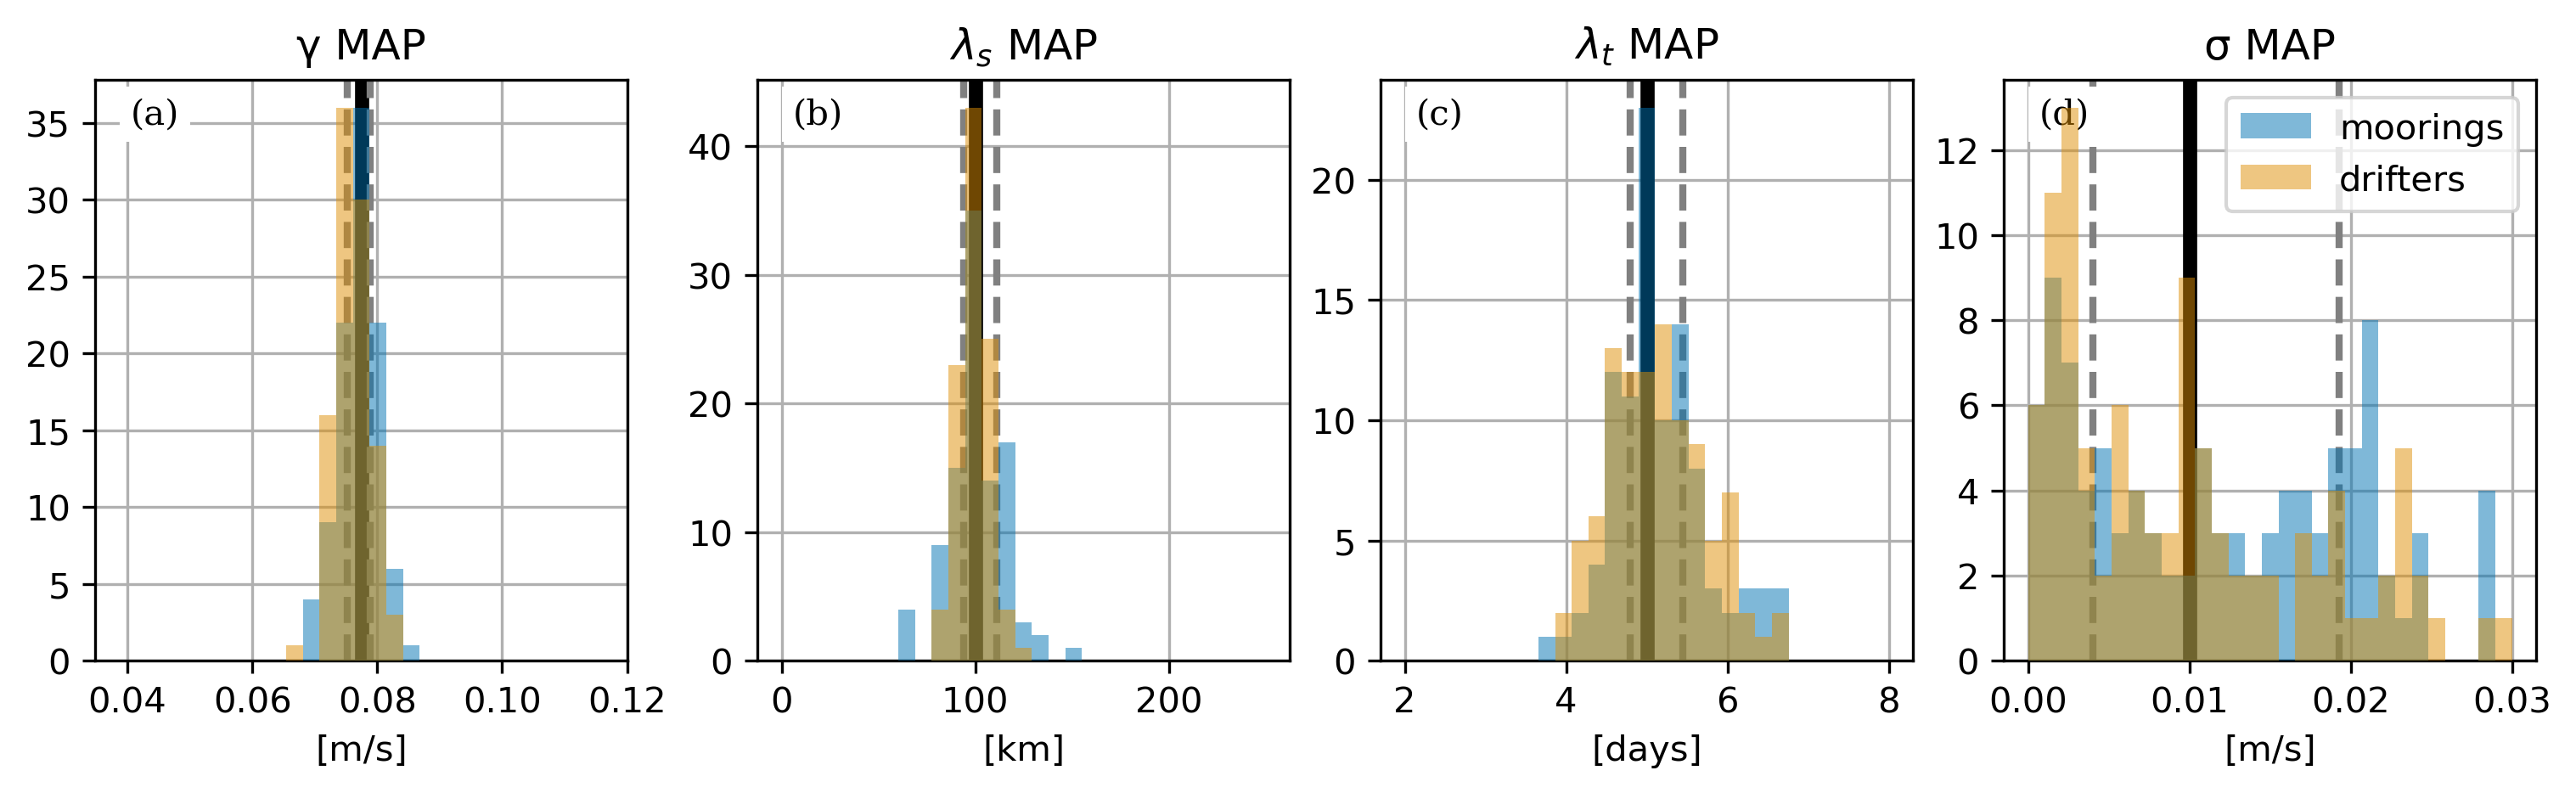

In [20]:
plot()

---
## mooring inference plot

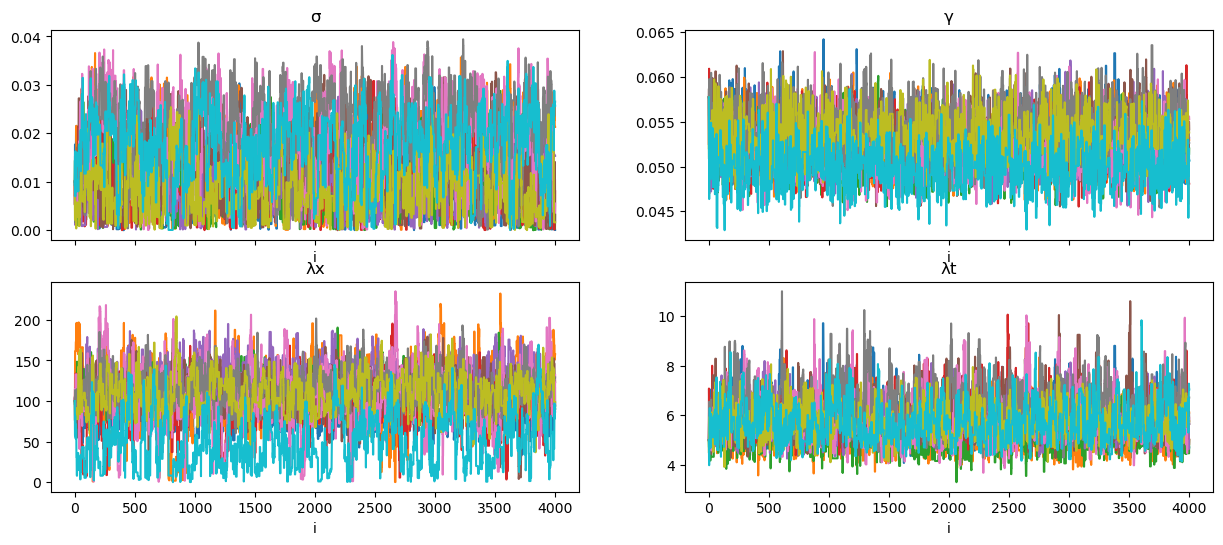

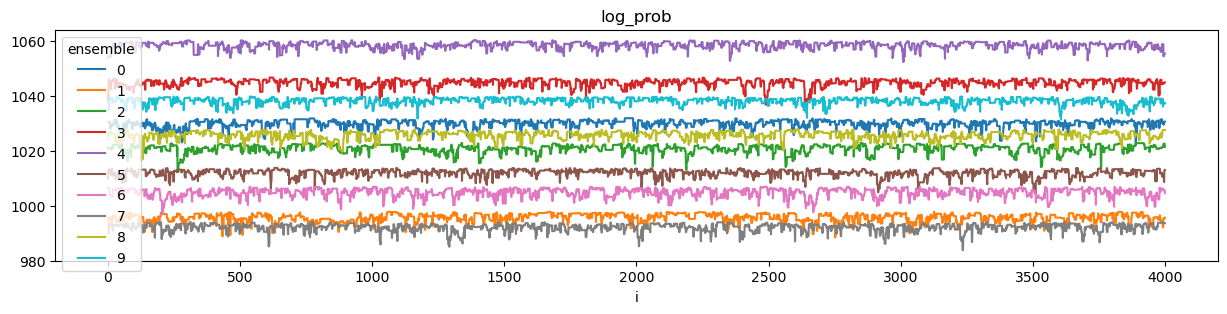

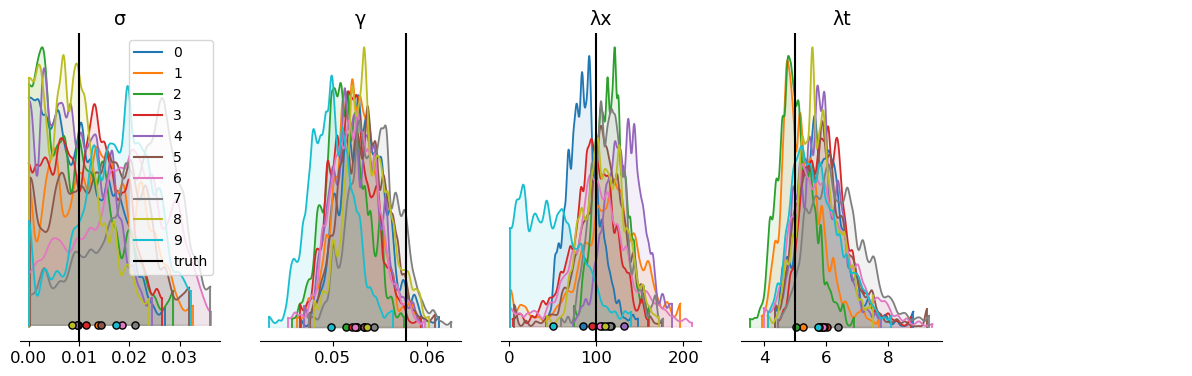

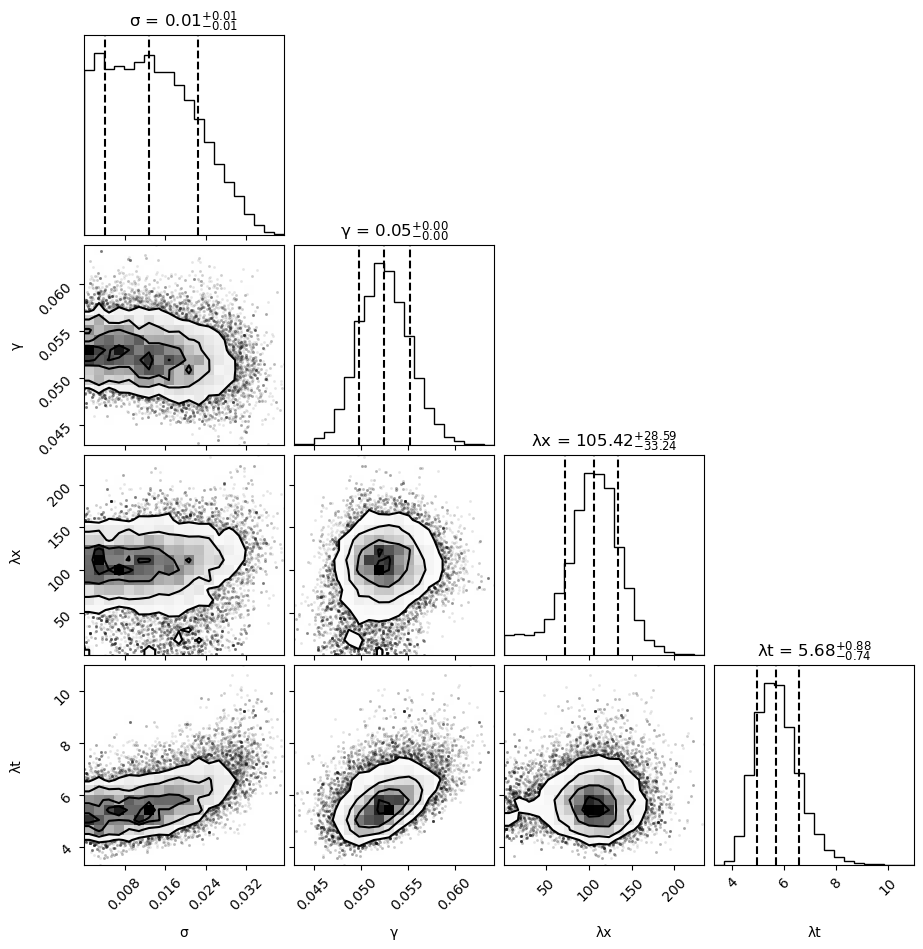

In [11]:
_ds = ds.sel(ensemble=slice(0,10))
st.traceplots(_ds, MAP=False)
st.plot_inference(_ds, xlim=False)

#### Empirical convergence metrics 

In [11]:
def show_convergence(ds):
    """ split time series in half and compare mean and std"""

    N = ds["i"].size
    ds0 = ds.isel(i=slice(0,N//2))
    ds0m = ds0.mean(["i"])
    ds0std = ds0.std(["i"])
    ds1 = ds.isel(i=slice(N//2,None))
    ds1m = ds1.mean(["i"])
    ds1std = ds1.std(["i"])

    # mean
    fig, axes = plt.subplots(ds.parameter.size,1,figsize=(5,5), sharex=True,)
    for p, ax in zip(ds.parameter.values, axes):
        _da = ds0m.sel(parameter=p).samples
        _da.plot(ax=ax)
        _da = ds1m.sel(parameter=p).samples
        _da.plot(ax=ax)
        ax.set_title(p+" mean")
        if p!=ds.parameter.values[-1]:
            ax.set_xlabel("")
    plt.subplots_adjust(hspace=0.5)

    # mean
    fig, axes = plt.subplots(ds.parameter.size,1,figsize=(5,5), sharex=True,)
    for p, ax in zip(ds.parameter.values, axes):
        _da = ds0std.sel(parameter=p).samples
        _da.plot(ax=ax)
        _da = ds1std.sel(parameter=p).samples
        _da.plot(ax=ax)
        ax.set_title(p+" std")
        if p!=ds.parameter.values[-1]:
            ax.set_xlabel("")
    plt.subplots_adjust(hspace=0.5)

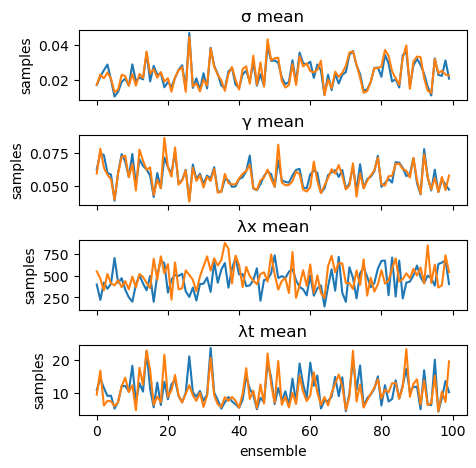

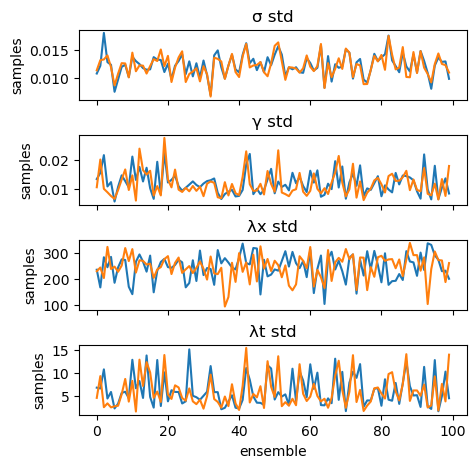

In [12]:
show_convergence(ds)

#### Effective sample size

In [13]:
samples = ds.samples.isel(ensemble=0).values
samples_az = st.convert_to_az(samples, labels)
Ndof = az.ess(samples_az)
print(Ndof)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    σ        float64 152.6
    γ        float64 533.2
    λx       float64 207.6
    λt       float64 212.4


#### MAP

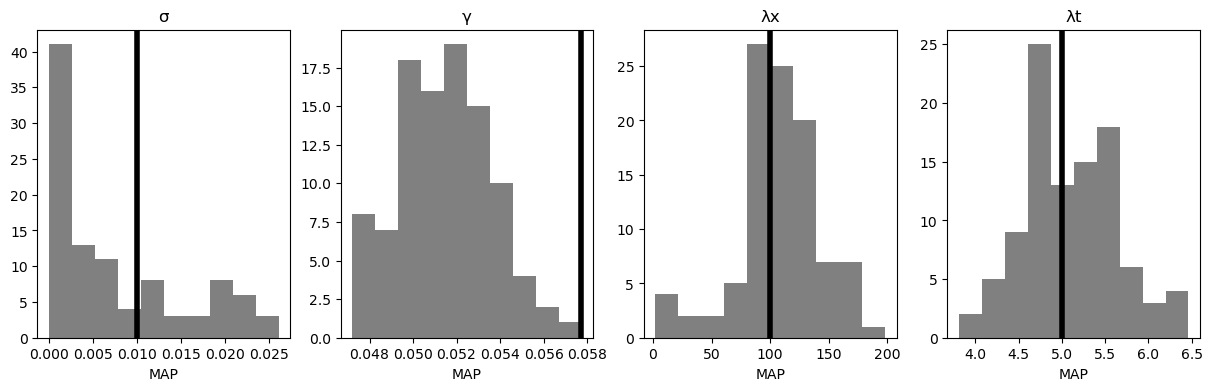

In [15]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _ds.MAP.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)) #+ " - MAP"
    ax.axvline(_tr, color="k", lw=4)

#### mean/std

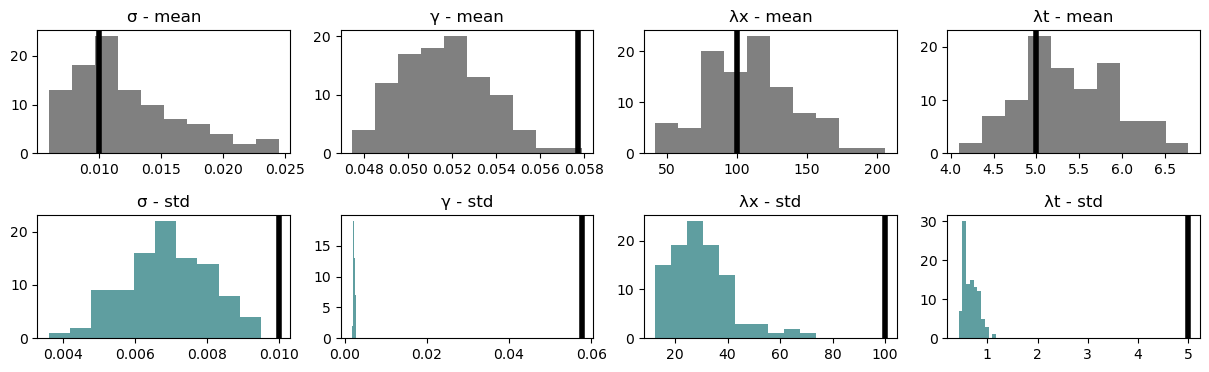

In [16]:
fig, axes = plt.subplots(2, ds.parameter.size, figsize=(15,4), gridspec_kw=dict(hspace=.5))

# mean
for p, ax in zip(ds.parameter, axes[0,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.mean("i")
    _da.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)+" - mean")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")
    
# std
for p, ax in zip(ds.parameter, axes[1,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.std("i")
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.set_title(str(p.values)+ " - std")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")

#### quantiles

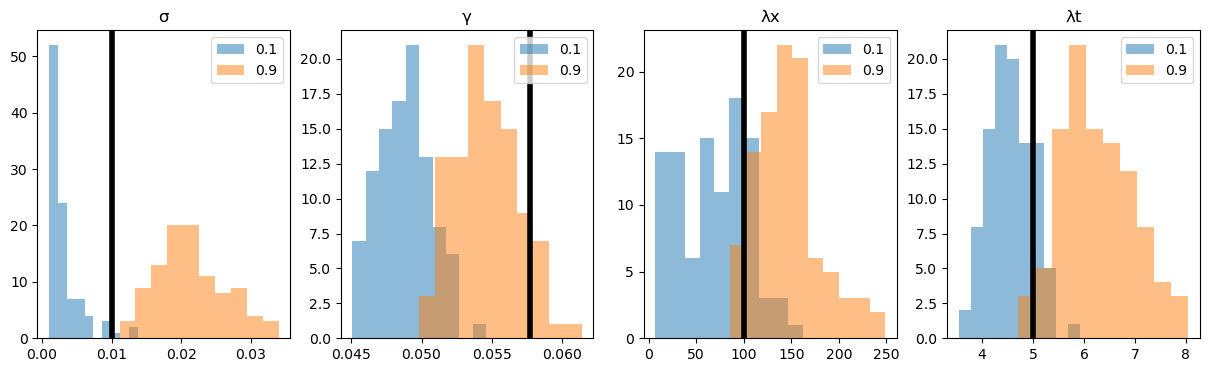

In [17]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    for q in qt:
        _da.sel(quantile=q).plot.hist(ax=ax, bins=10, alpha=.5, label=f"{q}")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")
    ax.legend()

##### quantiles 0.1 0.9 difference

this larger than std by a factor of about 2

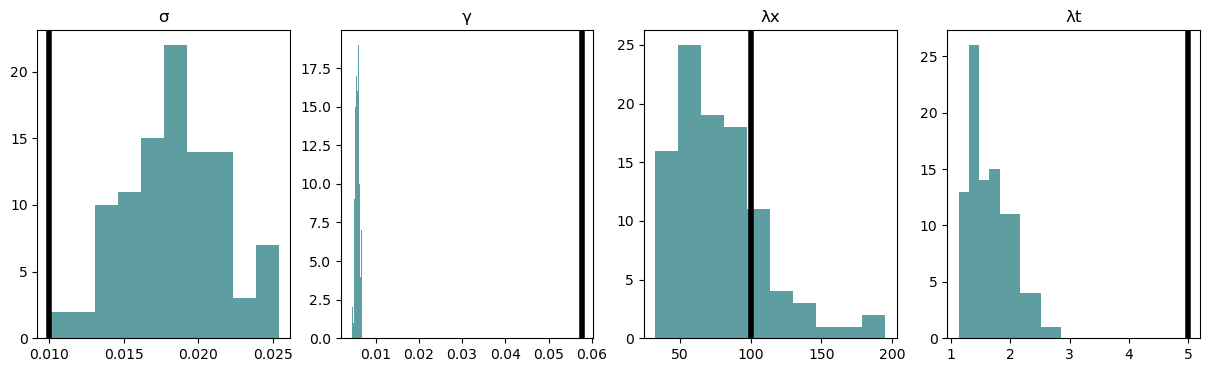

In [18]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _da = _da.sel(quantile=qt[1]) - _da.sel(quantile=qt[0])
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")

---
## drifter inference plot

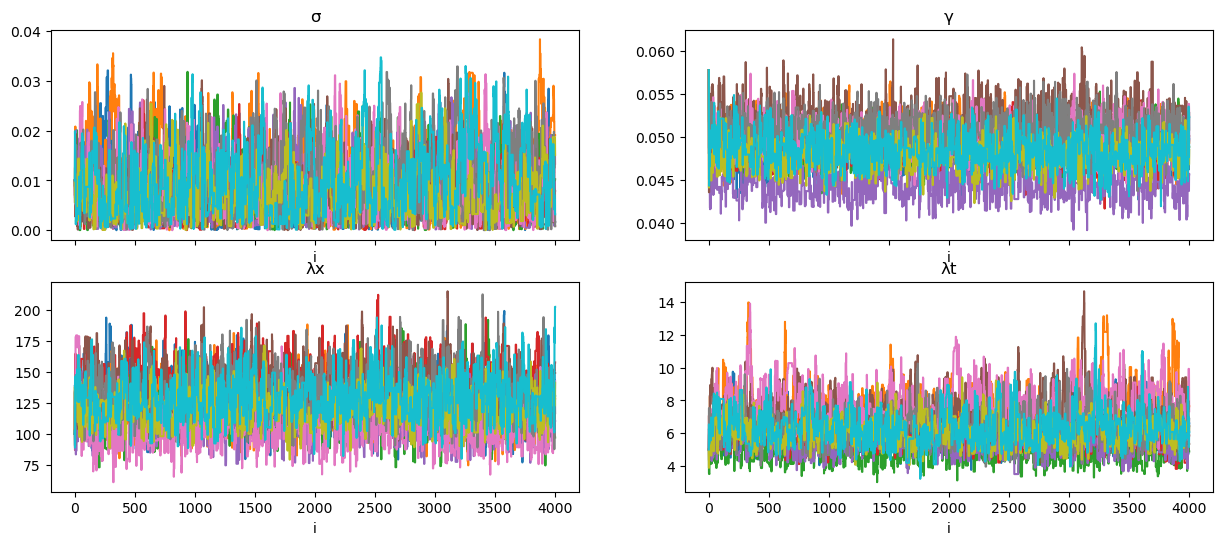

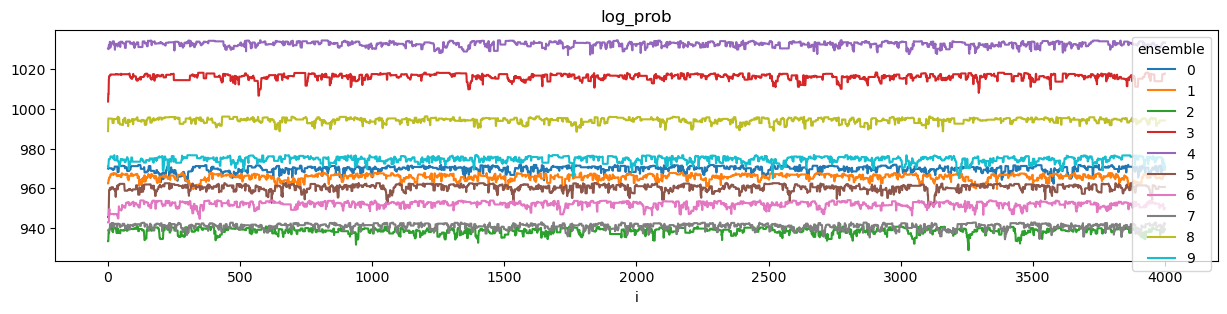

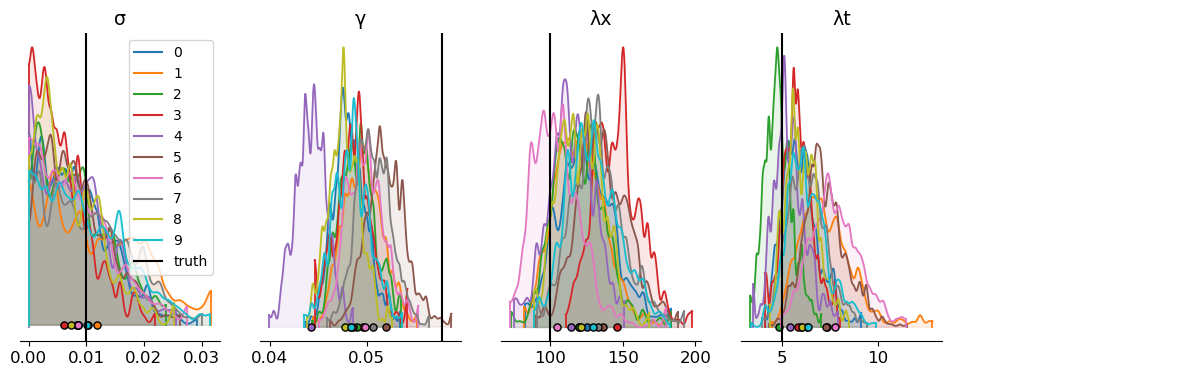

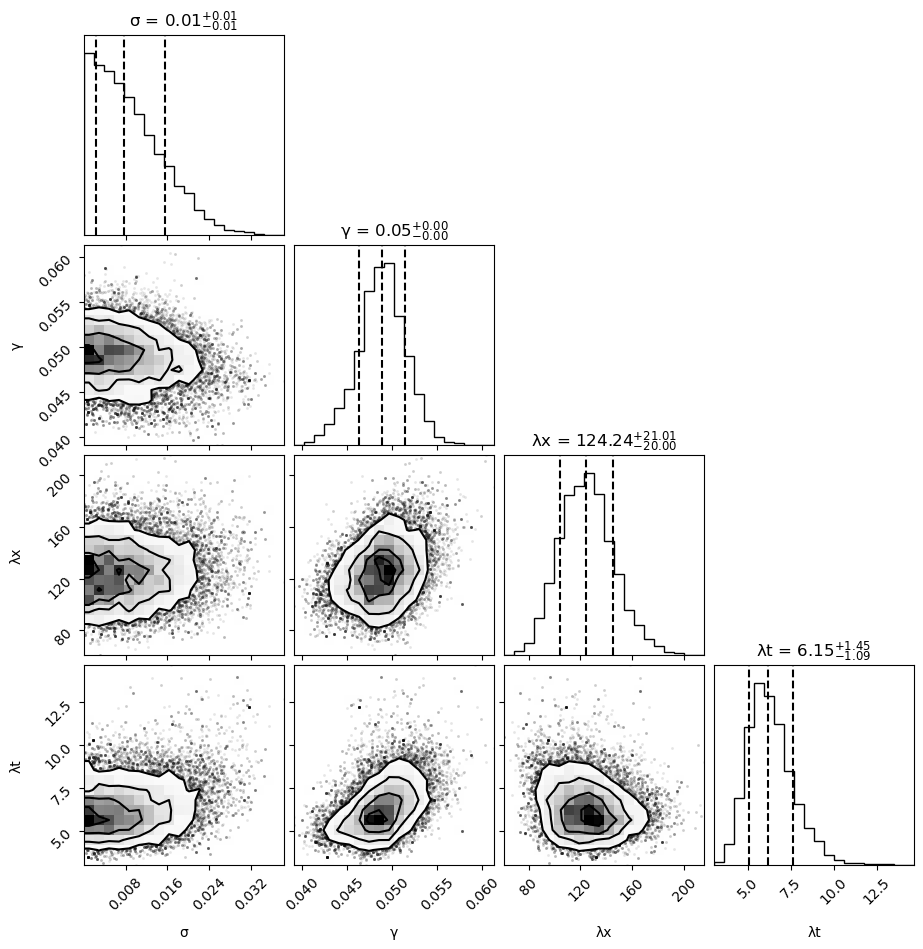

In [36]:
_ds = ds.sel(ensemble=slice(0,10))
st.traceplots(_ds, MAP=False)
st.plot_inference(_ds, xlim=False)

#### MAP

The underestimation of $\gamma$ may be related to interference with the noise parameter inference (see joint distributions above) and the fact we allow for substantial values of the noise compared to the $\gamma$ ... to be verified

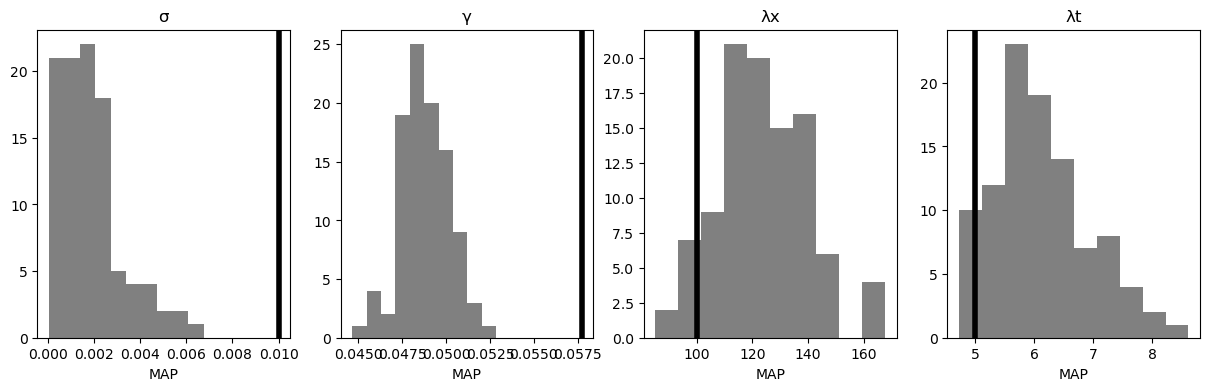

In [37]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _ds.MAP.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)) #+ " - MAP"
    ax.axvline(_tr, color="k", lw=4)

#### mean/std

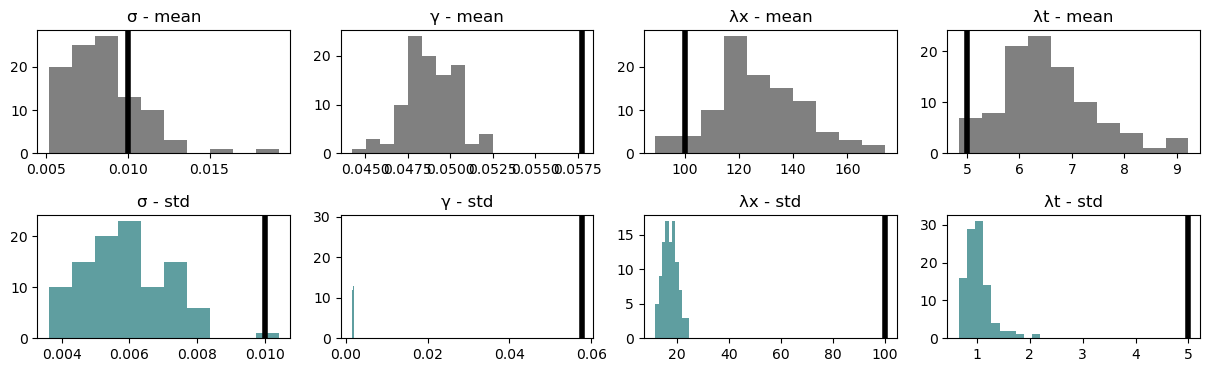

In [38]:
fig, axes = plt.subplots(2, ds.parameter.size, figsize=(15,4), gridspec_kw=dict(hspace=.5))

# mean
for p, ax in zip(ds.parameter, axes[0,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.mean("i")
    _da.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)+" - mean")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")
    
# std
for p, ax in zip(ds.parameter, axes[1,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.std("i")
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.set_title(str(p.values)+ " - std")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")

#### quantiles

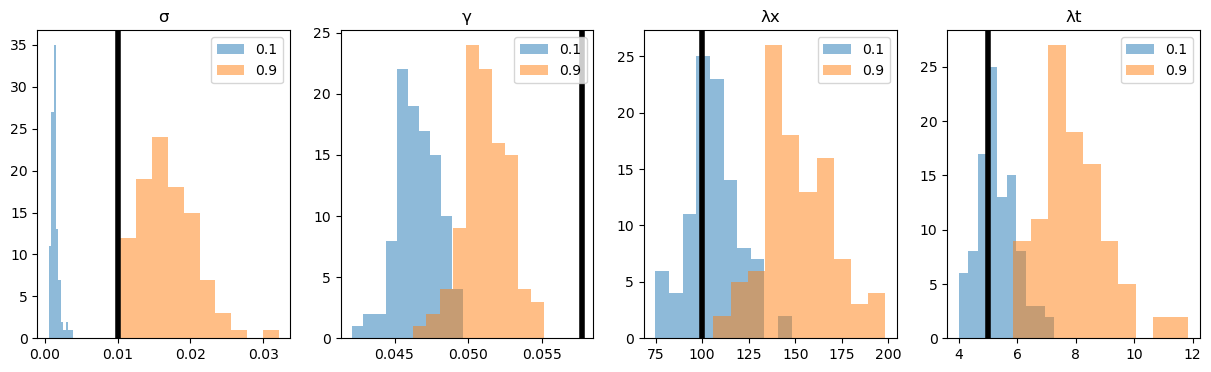

In [39]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    for q in qt:
        _da.sel(quantile=q).plot.hist(ax=ax, bins=10, alpha=.5, label=f"{q}")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")
    ax.legend()

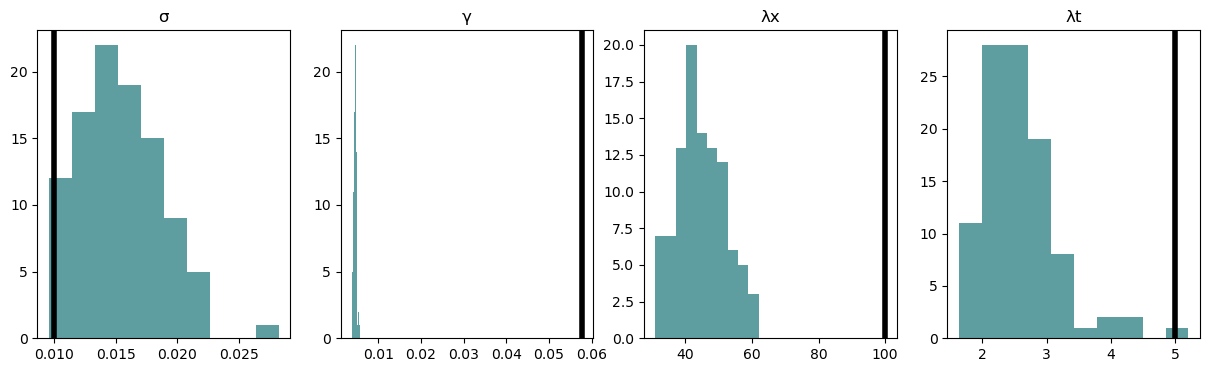

In [40]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _da = _da.sel(quantile=qt[1]) - _da.sel(quantile=qt[0])
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")